# Capstone Project: Stroke Risk Prediction #
This is a capstone project for Springboard's data science intensive track. The dataset used in this project is sourced from the data science competition sponsor by McKinsey analytics and held in a platform "Analytics Vidhya". 
The competition link can be found here [contest page] (https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon/).

**Dataset:**
The data source was contributed by a chain of hospital clients based in US for McKinsey consulting firm. McKinsey hosted this dataset as open data science hack competition on Analytics Vidhya. The dataset consists of 11 features on anonymized patients including mixed variables (i.e., numerical and categorical) such as patient ID, gender, health conditions and other demographic features. The volume of dataset contains about 43,000 patient cases.

**Goal:** 
To develop a classification model predicts patients at high risks of developing a stroke condition

**Results:**
87% of auc_roc score made on test set of patient population using Logistic Regression classifier.

**Risks:**
Model incorrectly identified with 25% of error (especially error being Type I error).

**Mitigation:**
Review identified cases with a group of clinicians before any clinical decision making

**Next Steps for Future Work:**
* Collection of meaningful features.
* Model improvement: algorithms, resampling strategies and classifier designs (i.e., age-specific)

**Recommendations for Clients:**
1. Implement additional stroke screening test at a recommended age (before 65-year-old)
2. Collect meaningful features for building an accurate model: stress level, physical activity, genetic factors, etc.
3. Conduct cohort studies: further study and stratify patient groups into diabetic and obese population based on given average glucose level and body mass index (BMI) defined by clinical study guidelines.

## Part 1 - DEFINE ##

**Problem Statement:** a chain of hospitals in US collected anonymized pool of patients data for stroke classification. Stroke is one of critical disease which affects nearly 1 in 20 Americans and is a disease that affects arteries leading to and within the brain. A stroke occurs when a blood vessel that carries oxygen and nutrients to the brain is either blocked by a clot or ruptures. When that happens part of the brain cannot get the blood (and oxygen) it needs, so the brain cells in the affected region is dead. The clients captured several lifestyle, health monitoring measurements and demographic factors about their anonymized patients. These include features like age, gender, health monitoring measurements (i.e., glucose level, body mass index) and lifestyle factors (i.e., smoking status, occupation type etc.). 

**Stakeholders:**
Hospital cardiac unit managers, a group of clinicians, insurance companies and employers from patient population.

In [1]:
# Import all libraries #
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
plt.style.use('ggplot')
import operator
from itertools import cycle
import scipy.stats as sp
from scipy import interp
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import sklearn.metrics as skm
import sklearn.base as skb
from sklearn.utils import shuffle, resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Authorship:
__author__ = 'Taesun Yoo'
__email__ = 'yoots1988@gmail.com'

C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Part 2 - DISCOVERY ##

In [2]:
#############################
# Part 2 - DISCOVER PHASE ###
#############################
# --- 1. Write Out List of Functions --- #
def load_file(file):
    '''load input CSVs as a dataframe'''
    return pd.read_csv(file, encoding='latin1')


def convert_dt_as_custom(df, var_name, dt_type):
    '''convert datatype on selected variables'''
    df[var_name] = df[var_name].astype(dt_type)
    return df[var_name]


def convert_dt_as_category(df):
    '''convert datatype from object to category'''
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].astype('category')            

        
def drop_column(df, var_name):
    ''' drop a column on dataframe '''
    df = df.drop(var_name, axis=1)
    return df


def clean_data(raw_df):
    '''remove rows that contain outliers'''
    clean_df = raw_df.drop_duplicates(subset='id')
    return clean_df
    

def join_data(df1, df2, join_type, key=None,
              left_index=None, right_index=None):
    '''merge the dataframes by a key'''
    df_join = pd.merge(df1, df2, how=join_type, on=key,
                       left_index=False, right_index=False)
    return df_join


def avg_groupby_data(cleaned_df, num_var, cat_var, avg_var_name):
    '''groupby categorical var to calculate an average numerical feature'''
    avg_groupby_cat_val = cleaned_df.groupby(cat_var)[num_var].mean().sort_values(ascending=False)
    avg_groupby_cat_df = pd.DataFrame({cat_var:list(cleaned_df[cat_var].unique()),
                                      avg_var_name:avg_groupby_cat_val})
    avg_groupby_cat_df.reset_index(drop=True, inplace=True)
    return avg_groupby_cat_df


def encode_categorical_feature(df, var_name, map_name):
    '''encode categorical features into mapping values'''
    df[var_name] = df[var_name].map(map_name)
    return df[var_name]


def EDA_missing_data(df):
    ''' compute missing value % on a df'''
    df_missing = pd.DataFrame(df.isnull().sum())
    df_missing.columns = ['count']
    df_missing = df_missing.sort_values(by='count', ascending=False)
    df_missing['pct'] = (df_missing['count']/len(df)) * 100
    return df_missing


def EDA_summary_stat_num(df):
    ''' compute numerical summary statistics '''
    df_stat_num = df.describe().T
    df_stat_num = df_stat_num[['count', 'min', 'mean', 'max', '25%', '50%', '75%', 'std']]
    df_stat_num = df_stat_num.sort_values(by='count', ascending=True)
    df_stat_num = pd.DataFrame(df_stat_num)
    return df_stat_num


def EDA_summary_stat_cat(df):
    ''' compute numerical summary statistics '''
    df_stat_cat = pd.DataFrame(df.describe(include='category').T)
    return df_stat_cat


def EDA_feature_importance_plot(model, X, y):
    '''plots the feature importance plot on trained model'''
    model = model
    model.fit(X, y)
    feat_labels = X.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), feat_labels[indices], rotation=90, fontsize=7)
    plt.xlim(-1, X.shape[1])


def feature_replacement(X):
    ''' replace missing values based on specific data type of a column '''
    for col in X.columns:
        if X[col].dtype.name == 'object':
            mode = X[col].mode().iloc[0]
            X[col] = X[col].fillna(mode)
        elif X[col].dtype.name == 'float64':
            mean = X[col].mean()
            X[col] = X[col].fillna(mean)
        else:
            X[col].dtype.name == 'int64'
            median = X[col].median()
            X[col] = X[col].fillna(median)


def apply_binning(df, new_var, old_var, bins, labels):
    '''apply binning on a selected variable'''
    df[new_var] = pd.cut(df[old_var], bins=bins,
                          labels=labels, include_lowest=True)
    return df[new_var]


def one_hot_encode_feature(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and
       combine results with numerical variables '''
    cat_df = pd.get_dummies(df[cat_vars], drop_first=True)
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)


def get_label_data(df, label_var):
    '''separate label from a dataframe'''
    df_label = df[label_var]
    return df_label


def feature_scale_data(X):
    '''Feature scaled data based on standardization'''
    sc_X = StandardScaler()
    X_std = sc_X.fit_transform(X)
    return X_std
    

def score_model_roc_auc(model, X_train, y_train, X_val, y_val):
    '''computes the roc_auc score for probability of being a stroke case'''
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_val)
    return skm.roc_auc_score(y_val, probs[:,1])


def model_tuning_param(model, feature_df, label_df, param_dist, n_iter):
    '''performs RandomizedSearchCV to tune model hyper-parameters'''
    random_search = RandomizedSearchCV(model, param_dist, n_iter, cv=5)
    random_search.fit(feature_df, label_df)
    return random_search


def print_best_param(random_search, param_1=None, param_2=None, param_3=None, param_4=None):
    '''print the best model parameter(s)'''
    print("Best " + param_1 + ":", random_search.best_estimator_.get_params()[param_1])
    print("Best " + param_2 + ":", random_search.best_estimator_.get_params()[param_2])
    print("Best " + param_3 + ":", random_search.best_estimator_.get_params()[param_3])
    print("Best " + param_4 + ":", random_search.best_estimator_.get_params()[param_4])


def model_train(model, feature_df, label_df, n_proc, mean_roc_auc, cv_std):
    '''train a model and output mean roc_auc and CV std.dev roc_auc'''
    roc_auc = cross_val_score(model, feature_df, label_df, n_jobs=n_proc,
                               cv=5, scoring='roc_auc')
    mean_roc_auc[model] = np.mean(roc_auc)
    cv_std[model] = np.std(roc_auc)    


def model_summary(model, mean_roc_auc, cv_std):
    '''print out the model performances'''
    print('\nModel:\n', model)
    print('Average roc_auc:\n', mean_roc_auc[model])
    print('Std. Dev during CV:\n', cv_std[model])    


def compute_confusion_matrix(y_act, y_pred):
    '''compute sklearn confusion matrix'''
    cm_model = skm.confusion_matrix(y_act, y_pred)
    return cm_model  


def plot_confusion_matrix(cm, classes):
    '''plot the confusion matrix of trained model'''
    fig, ax = plt.subplots(figsize=(10,10))
    cm = cm.astype('float')/cm.sum()
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt='.2f'
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt), ha='center', va='center',
                    color='white' if cm[i,j] > thresh else 'black')
    plt.xlabel('predicted label')
    plt.ylabel('true label')


def report_class_summary(model_name, y_act, y_pred):
    '''Write a classification summary report''' 
    print ('Accuracy of ' + model_name + ' is %0.2f'% skm.accuracy_score(y_act, y_pred))
    print ('Precision of ' + model_name + ' is %0.2f'% skm.precision_score(y_act, y_pred))
    print ('Recall of ' + model_name + ' is %0.2f'% skm.recall_score(y_act, y_pred))
    print ('ROC score of ' + model_name + ' is %0.2f'% skm.roc_auc_score(y_act, y_pred))
    
    
def model_results(model, mean_roc_auc, predictions, feature_importances):
    '''saves the model name, mean_roc_auc, predicted rate, and feature importances'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
        feature_importances.to_csv('feat_importances.csv')
        predictions.to_csv('pred_results_best.csv', index=False)

In [3]:
# --- 2. Load the data --- #
# define input CSVs:
if __name__ == '__main__':
    train_file = 'stroke_train.csv'
    test_file = 'stroke_test.csv'

# Load data
df_train = load_file(train_file)
df_test = load_file(test_file)

# define variables:
cat_vars = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_vars = ['age', 'avg_glucose_level', 'bmi']
label_var = 'stroke'

# check data types on dataframes:
df_train.info()

# --- 3. ETL - metadata format --- #


# --- 4. ETL - merging/subsetting data --- #
# create a dataframe with label:
df_label = df_train[['id', 'stroke']]

# drop a specified column:
df_train = drop_column(df_train, label_var)

# merge on a train set and label:
train_raw_df = join_data(df_train, df_label, 'inner', key='id')

# --- 5. ETL - cleaning data --- #
# clean data:
clean_train_df = shuffle(clean_data(train_raw_df)).reset_index(drop=True)
clean_test_df = shuffle(clean_data(df_test)).reset_index(drop=True)
del (df_train, df_test)

# create a dataframe: test set 'id'
df_test_id = clean_test_df['id']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


### Feature Encoding ###
Feature encoding is a process where features are encoded into right format. There are two types of feature encoding: ordinal and nominal feature encoding. Ordinal feature encoding is a type of encoding where feature actually contains information about "order" like increase or decrease in value (i.e., score level, date, etc). Whereas nominal feature encoding is a type of encoding where feature contains a class of label like gender (i.e., male or female). 

**Ordinal feature encoding:** smoking_status. 
Smoking status is a feature where it has an order of smoking level progresses from never smoked to frequent smoker.
Thus, smoking status gets mapped into numerical values then gets printed after ordinal feature encoding for checking data consistency.

**Nominal feature encoding:** hypertension and heart_disease.
These two feature(s) have meaning of different class labels being "Yes" or "No" but already pre-encoded as numerical value(s) being "1" or "0". The main reason why these features are re-encoded back into word string is for exploratory data analysis phase. It is best practice to keep data format consistent among same type of variable or feature like "ever_married" which is originally contained value as a string "Yes" or "No".

In [4]:
# --- 6. Feature Encoding --- #
# mapping nominal features into an integer:
#smoking_status_map = {'never smoked':0, 'formerly smoked':1, 'smokes':2}
hypertension_map = {0:'No', 1:'Yes'}    
heart_disease_map = {0:'No', 1:'Yes'}

# encode features on a train set:
clean_train_df['hypertension'] = encode_categorical_feature(clean_train_df, 'hypertension', hypertension_map)
clean_train_df['heart_disease'] = encode_categorical_feature(clean_train_df, 'heart_disease', heart_disease_map)

# encode features on a test set:
clean_test_df['hypertension'] = encode_categorical_feature(clean_test_df, 'hypertension', hypertension_map)
clean_test_df['heart_disease'] = encode_categorical_feature(clean_test_df, 'heart_disease', heart_disease_map)

### Feature Imputation ###

Let's compute feature imputation to replace missing values by following:
Mode: smoking_status
Mean: bmi (idx: 8, 9)
Note: how different types of features were treated by different univariate methods for missing value replacement.

First, 'smoking_status' was an ordinal (categorical) feature. Thus, it makes sense to replace missing values by most frequently occurred value (mode).
Second, 'bmi' was a numerical feature. Also the feature showed normal distributions upon plotting a histogram. Thus, this can be replaced by mean.

In [5]:
# --- 7. Feature Imputation --- #
# check missing: before imputation
df_missing_pre = EDA_missing_data(clean_train_df)
df_missing_pre

# feature imputation:
feature_replacement(clean_train_df)
feature_replacement(clean_test_df)

# check missing: after imputation
df_missing_post = EDA_missing_data(clean_train_df)
df_missing_post
del(df_missing_pre, df_missing_post)

### Feature Engineering ###
Using a groupby function and computing a mean to create a set of new feature(s) from existing feature(s).

In [6]:
# --- 8. Feature Engineering --- #
# average age by categorical variables:
df_avg_age_by_hypertension = avg_groupby_data(clean_train_df, 'age', 'hypertension', 'avg_age_hypertension')
df_avg_age_by_heart_disease = avg_groupby_data(clean_train_df, 'age', 'heart_disease', 'avg_age_heart_disease')
df_avg_age_by_gender = avg_groupby_data(clean_train_df, 'age', 'gender', 'avg_age_gender')
df_avg_age_by_work_type = avg_groupby_data(clean_train_df, 'age', 'work_type', 'avg_age_work_type')
df_avg_age_by_marital_status = avg_groupby_data(clean_train_df, 'age', 'ever_married', 'avg_age_marital_status')

# perform left joins on avg grouped dataframes:
clean_train_df = join_data(clean_train_df, df_avg_age_by_hypertension, 'left', key='hypertension')
clean_train_df = join_data(clean_train_df, df_avg_age_by_heart_disease, 'left', key='heart_disease')
clean_train_df = join_data(clean_train_df, df_avg_age_by_gender, 'left', key='gender')
clean_train_df = join_data(clean_train_df, df_avg_age_by_work_type, 'left', key='work_type')
clean_train_df = join_data(clean_train_df, df_avg_age_by_marital_status, 'left', key='ever_married')

clean_test_df = join_data(clean_test_df, df_avg_age_by_hypertension, 'left', key='hypertension')
clean_test_df = join_data(clean_test_df, df_avg_age_by_heart_disease, 'left', key='heart_disease')
clean_test_df = join_data(clean_test_df, df_avg_age_by_gender, 'left', key='gender')
clean_test_df = join_data(clean_test_df, df_avg_age_by_work_type, 'left', key='work_type')
clean_test_df = join_data(clean_test_df, df_avg_age_by_marital_status, 'left', key='ever_married')

In [7]:
# --- 9. Exploratory Data Analysis --- #
# convert data type as category:
convert_dt_as_category(clean_train_df)
convert_dt_as_category(clean_test_df)

# perform summary statistics: numerical
df_stat_num = EDA_summary_stat_num(clean_train_df[num_vars])
df_stat_num

,count,min,mean,max,25%,50%,75%,std
age,43400.0,0.08,42.217894,82.00,24.00,44.00,60.00,22.519649
avg_glucose_level,43400.0,55.00,104.482750,291.05,77.54,91.58,112.07,43.111751
bmi,43400.0,10.10,28.605038,97.60,23.40,28.10,32.60,7.638023


In [8]:
# perform summary statistics: categorical
df_stat_cat = EDA_summary_stat_cat(clean_train_df)
df_stat_cat

,count,unique,top,freq
gender,43400,3,Female,25665
hypertension,43400,2,No,39339
heart_disease,43400,2,No,41338
ever_married,43400,2,Yes,27938
work_type,43400,5,Private,24834
Residence_type,43400,2,Urban,21756
smoking_status,43400,3,never smoked,29345


### One-Hot Encoding: Dummy Variables ###
One-Hot-Encoding on nominal feature allows to create a separate column on each feature and its value are only encoded "0" or "1". This dummy indicator gets interpreted the ML models for making accurate predictions.

Also to reduce any potential biases of having multi-colinearity, each feature's first encoded dummy variable must be dropped to avoid dummy variable trap (i.e., where independent variables are highly inter-correlated with each other as one predictor can be predicted from other of similar variables: gender_female vs. gender_male vs. gender_other).

In [9]:
# --- 10. Prepare Training Data --- #
# list of categorical and numerical features:
cat_feat = list(clean_test_df.select_dtypes(include='category').columns)
num_feat = list(clean_train_df.select_dtypes(include='float64').columns)

# one-hot encoding and concatenate numerical & categorical:
feature_df = one_hot_encode_feature(clean_train_df, cat_vars=cat_feat, num_vars=num_feat)
test_df = one_hot_encode_feature(clean_test_df, cat_vars=cat_feat, num_vars=num_feat)

# retrieve a label: stroke
label_df = get_label_data(clean_train_df, label_var)

# delete dataframes:
del(clean_train_df, clean_test_df)

### SMOTE: Re-Sampling ###
A given stroke patient dataset is highly imbalanced where majority of cases were non-stroke (98%) and only 2% (stroke). This is the most common problem for the classifier model which will likely to predict as a non-stroke patient in many cases.

Thus, resampling technique was applied to resolve this imbalanced classes posed on this dataset. SMOTE is one of the most common algorithm(s) that are used heavily to resolve this problem. The algorithm can perform over-sampling or down-sampling to increase or decrease the sample size on a specified label (i.e., non-stroke:0, stroke:1). 

In this case, the over-sampling was performed on the minority class label (i.e., stroke cases) to increase the available sample size for model training.

In [10]:
# --- 11. split data into train and test set --- # 
X_train, X_val, y_train, y_val = train_test_split(feature_df, label_df, test_size=.3,
                                                    random_state=0, stratify=label_df)

# --- SMOTE: oversample on minority class label --- #
sm = SMOTE(random_state=0, ratio='minority', n_jobs=-1)
X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)

# count rows on resampled label:
pd.value_counts(y_train_resampled)

1    29832
0    29832
dtype: int64

In [11]:
# --- 12. Feature seleciton: Feature Importance --- # 
# Establish a baseline model:
baseline = RandomForestClassifier(n_estimators=100, n_jobs=-1)
baseline.fit(X_train_resampled, y_train_resampled)

# Make predicted probabilities:
probs = baseline.predict_proba(X_val)
#predictions = baseline.predict(X_val)

# compute a roc_auc score on stroke cases only:
skm.roc_auc_score(y_val, probs[:,1]) 

# basline predictions: test results
test_probs = baseline.predict_proba(test_df)

# save a dataframe: test results
results = pd.DataFrame({'id':df_test_id,
                        'stroke':test_probs[:,1]})
    
results.to_csv('test_baseline.csv', index=False, index_label=None)

## Part 3 - DEVELOP ##

In [12]:
############################
# Part 3 - DEVELOP PHASE ###
############################
# --- 13. create models --- # 
# initialize model list and dicts
models = []
mean_roc_auc = {}
cv_std = {}
res = {}

# define common model parameters: num processors and shared model parameters
n_proc = 1
verbose_lv = 5

# create and tune the models that you brainstormed during part 2
###############################################################################        
# Hyper-parameters tuning: LogisticRegression
lr = LogisticRegression()
n_iter = 10
param_dist_lr = dict(tol=np.random.uniform(0, 0.0001, 10), C=sp.randint(1,50),
                     penalty=['l1', 'l2'], solver=['liblinear','saga'])
random_search_lr = model_tuning_param(lr, X_train_resampled, y_train_resampled, param_dist_lr, n_iter)

# print the best model parameters: LogisticRegression    
param_1 = 'tol'
param_2 = 'C'
param_3 = 'penalty'
param_4 = 'solver'

print_best_param(random_search_lr, param_1, param_2, param_3, param_4)
###############################################################################        
# Hyper-parameters tuning: DecisionTree
tree = DecisionTreeClassifier(criterion='gini', random_state=0)

n_iter = 10
param_dist_tree = {'max_depth': sp.randint(10,100),
                 'min_samples_split': sp.randint(2,10),
                 'min_samples_leaf': sp.randint(2,10),
                 'max_features': sp.randint(2,10)}

random_search_tree = model_tuning_param(tree, X_train_resampled, y_train_resampled, param_dist_tree, n_iter)

# print the best model parameters: LogisticRegression    
param_1 = 'max_depth'
param_2 = 'min_samples_split'
param_3 = 'min_samples_leaf'
param_4 = 'max_features'

print_best_param(random_search_tree, param_1, param_2, param_3, param_4)
###############################################################################        
# Hyper-parameters tuning: RandomForest
forest = RandomForestClassifier(criterion='gini', random_state=0)

n_iter = 10
param_dist_forest = {'n_estimators': sp.randint(10,100),
                     'max_depth': sp.randint(10,100),
                     'min_samples_split': sp.randint(2,10),
                     'min_samples_leaf': sp.randint(2,10)}

random_search_forest = model_tuning_param(forest, X_train_resampled, y_train_resampled, param_dist_forest, n_iter)

# print the best model parameters: LogisticRegression    
param_1 = 'n_estimators'
param_2 = 'max_depth'
param_3 = 'min_samples_split'
param_4 = 'min_samples_leaf'

print_best_param(random_search_forest, param_1, param_2, param_3, param_4)
###############################################################################    
# Hyper-parameters tuning: XGBoost
xgb = XGBClassifier(random_state=0)
n_iter = 10

param_dist_xgb = {'n_estimators': sp.randint(10,100),
                 'max_depth': sp.randint(10,100),
                 'colsample_bytree': np.random.uniform(0, 1, 10),
                 'learning_rate': np.random.uniform(0, 1, 10)}

random_search_xgb = model_tuning_param(xgb, X_train_resampled, y_train_resampled, param_dist_xgb, n_iter)

# print the best model parameters: LogisticRegression    
param_1 = 'n_estimators'
param_2 = 'max_depth'
param_3 = 'colsample_bytree'
param_4 = 'learning_rate'

print_best_param(random_search_xgb, param_1, param_2, param_3, param_4)
###############################################################################  

C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

Best tol: 9.750497902514769e-05
Best C: 20
Best penalty: l2
Best solver: saga
Best max_depth: 89
Best min_samples_split: 9
Best min_samples_leaf: 3
Best max_features: 8
Best n_estimators: 57
Best max_depth: 25
Best min_samples_split: 5
Best min_samples_leaf: 3
Best n_estimators: 78
Best max_depth: 31
Best colsample_bytree: 0.6906413094251105
Best learning_rate: 0.22868736803523204


In [13]:
# --- 14. cross-validate models --- # 
# a list of models to train: 5 fold cross-validation
lr = LogisticRegression(tol=1.8213e-05, C=26, penalty='l2', solver='saga')
tree = DecisionTreeClassifier(max_depth=19, min_samples_split=9, min_samples_leaf=2,
                              max_features=9, random_state=0)
forest = RandomForestClassifier(n_estimators=86, max_depth=76, min_samples_split=5,
                                min_samples_leaf=2, random_state=0) 
xgb = XGBClassifier(n_estimators=78, max_depth=85, colsample_bytree=0.3704,
                    learning_rate=0.0671, random_state=0)

# a list of classifiers:
models.extend([lr, tree, forest, xgb])

# cross-validate models, using roc_auc to evaluate and print the summaries
print('begin cross-validation')
for model in models:
    model_train(model, X_train_resampled, y_train_resampled, n_proc, mean_roc_auc, cv_std)
    model_summary(model, mean_roc_auc, cv_std)
    
# --- 15. select the best model --- #
model = max(mean_roc_auc, key=mean_roc_auc.get)
print('\nBest model with the highest mean roc_auc:')
print(model)

begin cross-validation


C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not c


Model:
 LogisticRegression(C=26, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=1.8213e-05, verbose=0,
                   warm_start=False)
Average roc_auc:
 0.850013874279773
Std. Dev during CV:
 0.002950577712019221

Model:
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19,
                       max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
Average roc_auc:
 0.9863074357273394
Std. Dev during CV:
 0.01407687725311061

Model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                

### Model Evaluation: using Feature Selection ###
Compute a roc_auc score on "stroke cases" for following models:
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* XGBoost Classifier

In [14]:
# --- compute a roc_auc score on "stroke cases" --- #
score_model_roc_auc(xgb, X_train_resampled,
                    y_train_resampled, X_val.values, y_val)

score_model_roc_auc(tree, X_train_resampled,
                    y_train_resampled, X_val, y_val)

score_model_roc_auc(forest, X_train_resampled,
                    y_train_resampled, X_val, y_val)

score_model_roc_auc(lr, X_train_resampled,
                    y_train_resampled, X_val, y_val)

C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8657605738107323

### Model 1: Logistic Regression ###
Logistic regression works by using a logit function to transform input value of features and calculate estimated probabilities of a label in range of [0,1]. For example, if P(1=stroke) ≥ 0.5, an observation is predicted as a stroke. Whereas if P(1=stroke) < 0.5, an observation is predicted as a non-stroke.

### Model 2: Decision Tree ###
Decision tree is an algorithm where it predicts the value of a target variable (label) by learning simple decision rules inferred from selected features. Tree is generated and split data on features. It continues to split in repetitive process at each node until leaves reached purity (i.e., remaining samples at each node belongs to same class either non-stroke or stroke cases only).

### Model 3: Random Forest ###
Random forest is a typical ensemble learning model. It takes random subsample of data from each tree, so all constructed trees are different from each other. Thus, model makes classification based on predictions made from each tree with averaging (i.e., like picking a vote from majority).

### Model 4: XGBoost ###
XGBoost is a type of gradient boosting model in which subsequent model learns from the mistakes (i.e., residual errors) of previous model in a step-wise forward manner. In Gradient Boosting, residual errors are identified gradients. These gradients help how XGBoost to improve model performances.

## Model Evaluation: Confusion Matrix ##
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.
1. True Positives (TP): These are cases in which model predicted yes (they have the disease), and they do have the disease.
2. True Negatives (TN): Model predicted no, and they don't have the disease.
3. False Positives (FP): Model predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
4. False Negatives (FN): Model predicted no, but they actually do have the disease. (Also known as a "Type II error.")

C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


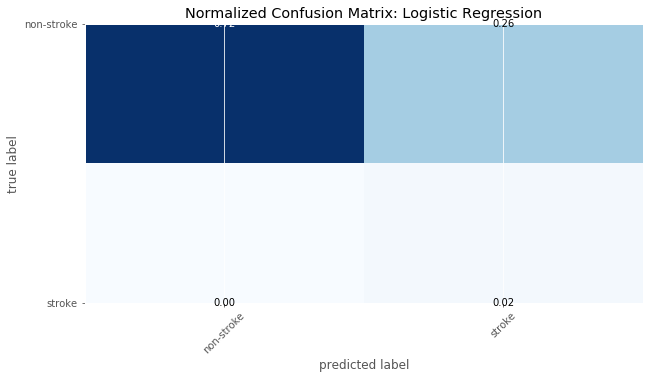

Accuracy of Logistic Regression is 0.74
Precision of Logistic Regression is 0.06
Recall of Logistic Regression is 0.85
ROC score of Logistic Regression is 0.79


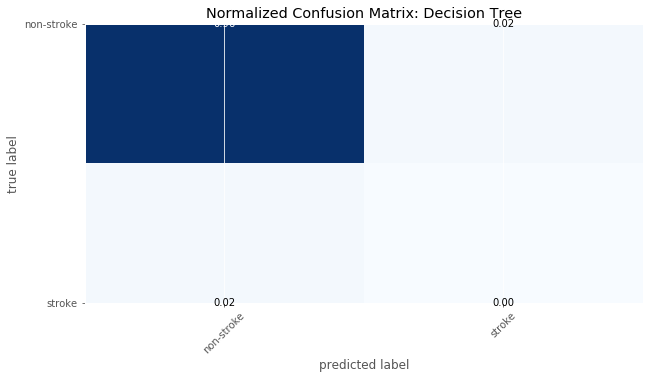

Accuracy of Decision Tree is 0.96
Precision of Decision Tree is 0.04
Recall of Decision Tree is 0.05
ROC score of Decision Tree is 0.51


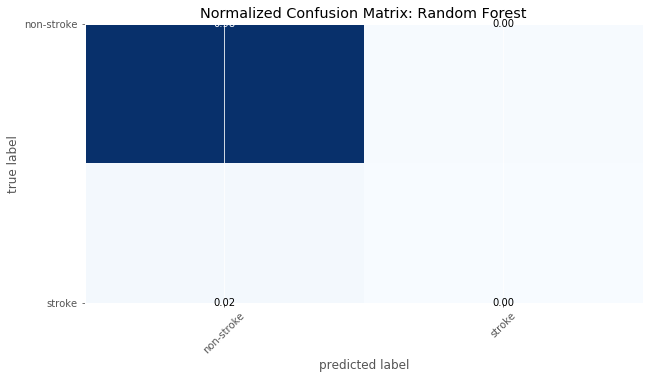

Accuracy of Random Forest is 0.98
Precision of Random Forest is 0.06
Recall of Random Forest is 0.02
ROC score of Random Forest is 0.51


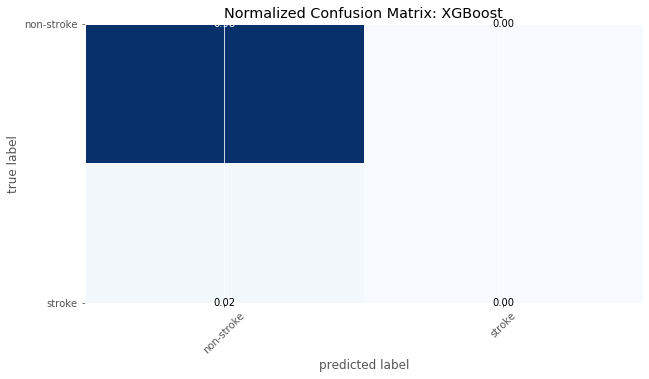

Accuracy of XGBoost is 0.98
Precision of XGBoost is 0.00
Recall of XGBoost is 0.00
ROC score of XGBoost is 0.50


In [15]:
# --- 16. Model Evaluation ---    
# compute predictions by a model:
lr.fit(X_train_resampled, y_train_resampled)
y_pred_lr = lr.predict(X_val)

tree.fit(X_train_resampled, y_train_resampled)
y_pred_tree = tree.predict(X_val)

forest.fit(X_train_resampled, y_train_resampled)
y_pred_forest = forest.predict(X_val)

xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb.predict(X_val.values)

# compute confusion matrices by a model:
cm_lr = compute_confusion_matrix(y_val, y_pred_lr)

cm_tree = compute_confusion_matrix(y_val, y_pred_tree)

cm_forest = compute_confusion_matrix(y_val, y_pred_forest)

cm_xgb = compute_confusion_matrix(y_val, y_pred_xgb)

# Define class labels for stroke:
class_labels = np.array(['non-stroke', 'stroke'], dtype=str)

#####################################################
# Confusion Matrix & Classification Metrics Summary #
#####################################################
# --- Model 1 --- #
# Plot a confusion matrix: 
plot_confusion_matrix(cm_lr, class_labels)
plt.title('Normalized Confusion Matrix: Logistic Regression')
plt.show()

# Report classification metrics summary:
report_class_summary('Logistic Regression', y_val, y_pred_lr)

# --- Model 2 --- #
# Plot a confusion matrix: 
plot_confusion_matrix(cm_tree, class_labels)
plt.title('Normalized Confusion Matrix: Decision Tree')
plt.show()

# Report classification metrics summary:
report_class_summary('Decision Tree', y_val, y_pred_tree)

# --- Model 3 --- #
# Plot a confusion matrix: 
plot_confusion_matrix(cm_forest, class_labels)
plt.title('Normalized Confusion Matrix: Random Forest')
plt.show()

# Report classification metrics summary:
report_class_summary('Random Forest', y_val, y_pred_forest)

# --- Model 4 --- #
# Plot a confusion matrix: 
plot_confusion_matrix(cm_xgb, class_labels)
plt.title('Normalized Confusion Matrix: XGBoost')
plt.show()

# Report classification metrics summary:
report_class_summary('XGBoost', y_val, y_pred_xgb)

## Model Evaluation: ROC Curve ##
ROC curve typically displays true positive rate on the Y-axis, and false positive rate on the X-axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better. The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


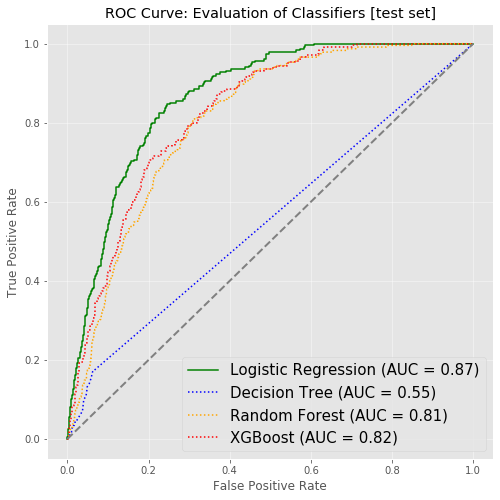

In [16]:
# --- 17. Model Plotting --- 
# ROC for each classifiers
clf_labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
all_clf = [lr, tree, forest, xgb]

# plot a ROC_AUC curve:
plt.figure(figsize=(8,8))
colors = ['green', 'blue', 'orange', 'red']
linestyles = ['-', ':', ':', ':'] 
for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):  
        # Assume the label of the positive class is 1
        y_pred = clf.fit(X_train_resampled,
                         y_train_resampled).predict_proba(X_val.values)[:,1]
        fpr, tpr, thresholds = skm.roc_curve(y_true=y_val, y_score=y_pred)
        roc_auc = skm.auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, color=clr, linestyle=ls,
                 label='%s (AUC = %0.2f)' % (label, roc_auc))
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(alpha=0.5)
plt.title('ROC Curve: Evaluation of Classifiers [test set]')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', prop={'size': 15})
plt.show()

### Summary of ROC Curve ###
This plot showed performance of all five models area under the curve. The best model had about AUC = 0.87 for logistic regression model. This indicated that about 87% of time model is good at separation of stroke cases from non-stroke cases.

## Part 4 - DEPLOY ##

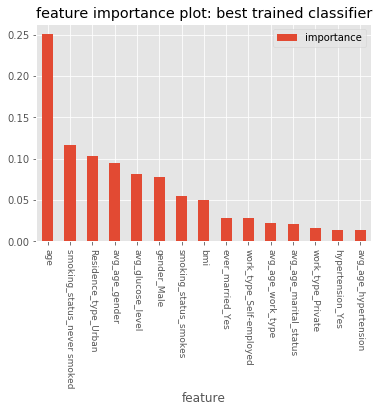

In [17]:
###########################
# Part 4 - DEPLOY PHASE ###
###########################
# --- 18. automate the model pipeline --- #
# make predictions on a test set:
df_pred_probs = lr.predict_proba(test_df)

# make predictions dataframe:
results = pd.DataFrame({'id':df_test_id,
                        'stroke':df_pred_probs[:,1]})
results.to_csv('prob_results_lr.csv', index=False, index_label=None)

# --- 19. deploy the solution --- #
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
# linear models don't have feature_importances_
    importances = [0]*len(X_train.columns)

# sort a dataframe by feature importance score: 
feature_importances = pd.DataFrame({'feature':X_train.columns,
                                        'importance':importances})
feature_importances.sort_values(by='importance', inplace=True, ascending=False)

# set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

# create a bar plot:    
feature_importances[0:15].plot.bar(align='center')
plt.xticks(rotation=270, fontsize=9)
plt.title('feature importance plot: best trained classifier')
plt.show()
    
# save model results as .csv file:
model_results(model, mean_roc_auc[model], results, feature_importances)

### Model Summary: Feature Importance ###
A figure showed the feature importance on the best trained model from order of the highest to lowest feature importance ranks.

Top 10 important features were age followed by smoking_status_never_smoked, residence_type_urban, avg. age by gender, etc.